# CO2的排量预测，使用pytorch lightning框架示例
## 导入所需的库

! pip install pytorch-lightning

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from scipy.stats import yeojohnson, yeojohnson_normmax, yeojohnson_llf
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from torch import nn
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

print("zxhnb")

zxhnb


## 数据预处理

In [2]:
def preprocess_data(file_path):
    data = pd.read_csv(file_path, encoding='gbk')
    
    data['entry_date'] = pd.to_datetime(data['entry_date'])
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    
    data['duration'] = (data['departure_date'] - data['entry_date']).dt.days
    
    pt = PowerTransformer(method='box-cox')
    data['CO2排放总量_transformed'] = pt.fit_transform(data['CO2排放总量'].values.reshape(-1, 1)) # 进行Yeo-Johnson变换
    
    data = data.sort_values(by='duration', ascending=False)
    
    return data, pt

## 定义数据集（继承自Dataset）

In [3]:
class EmissionsDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.features = data[['duration']].values
        self.labels = data['CO2排放总量_transformed'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature, label

## pl的数据模块

In [4]:
class EmissionsDataModule(pl.LightningDataModule):
    def __init__(self, hparams, df, pt):
        super().__init__()
        self.batch_size = hparams.batch_size
        self.num_workers = hparams.num_workers
        self.df = df
        self.pt = pt
        self.init_seed = hparams.init_seed

    def setup(self, stage=None): # 划分数据集
        dataset = EmissionsDataset(self.df)

        train_and_val_dataset, self.test_dataset = train_test_split(dataset, test_size=0.1, random_state=self.init_seed)
        self.train_dataset, self.val_dataset = train_test_split(train_and_val_dataset, test_size=0.1, random_state=self.init_seed)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

## 定义所有神经网络
### RNN

In [5]:
class RNNModel(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=2, input_dim=1, output_dim=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

### GRU 结合 Transformer

In [6]:
class GRUModel(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=2, input_dim=1, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=2)
        self.ln = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, hidden_dim)
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        at_out, _ = self.attention(out, out, out)
        out = self.ln(out + at_out)
        out = self.ffn(out)
        out = self.ln(out + at_out)
        out = self.fc(out[:, -1, :])
        return out

### LSTM

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=2, input_dim=1, output_dim=1, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

        self.batchnorm = nn.BatchNorm1d(hidden_dim * 2 if bidirectional else hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 初始化 LSTM 隐藏状态
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出，并送入全连接层
        out = self.dropout(self.batchnorm(out[:, -1, :]))

        out = self.fc(out)
        return out


### FC (Linear)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, hidden_dim=64, input_dim=1, output_dim=1, is_linear=False):
        super(FullyConnected, self).__init__()
        self.is_linear = is_linear
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.only = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        if self.is_linear:
            x = self.only(x)
        else:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
        return x

## pytorch lightning module
## 在这里，只需要将模型导入，并重写training_step, validation_step, test_step以及optimizer

In [9]:
from sklearn.metrics import r2_score

class EmissionsPredictor(pl.LightningModule):
    def __init__(self, hparams, pt):
        super(EmissionsPredictor, self).__init__()
        self.save_hyperparameters(hparams) # 保存超参数
        self.pt = pt
        self.model_type = hparams.model_type

        if self.model_type == 'RNN':
            self.model = RNNModel(hidden_dim=hparams.hidden_dim, num_layers=hparams.num_layers)
        elif self.model_type == 'GRU':
            self.model = GRUModel(hidden_dim=hparams.hidden_dim, num_layers=hparams.num_layers)
        elif self.model_type == 'LSTM':
            self.model = LSTMModel(hidden_dim=hparams.hidden_dim, num_layers=hparams.num_layers, bidirectional=hparams.bidirectional)
        elif self.model_type == 'FC':
            self.model = FullyConnected(hidden_dim=hparams.hidden_dim, is_linear=False)
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
        
        self.criterion = nn.L1Loss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        train_loss = self.criterion(y_hat, y)
        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        return {'loss' : train_loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        val_loss = self.criterion(y_hat, y)
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)
        return {'val_loss' : val_loss}

    def test_step(self, batch, batch_idx):
        features, labels_transformed = batch
        outputs = self(features).squeeze()
        
        # 逆变换
        original_predictions = self.pt.inverse_transform(outputs.cpu().numpy().reshape(-1, 1))
        original_labels = self.pt.inverse_transform(labels_transformed.cpu().numpy().reshape(-1, 1))
        
        # 计算原始尺度的MAE
        mae = mean_absolute_error(original_labels, original_predictions)
        test_r2 = r2_score(original_labels, original_predictions)

        self.log_dict({'test_mae': mae, 'test_r2': test_r2}, on_epoch=True, prog_bar=True)
        
        return mae

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

## 定义一个callback模块用于画图
### 如果没有安装matplotlib，需要先安装

! pip install matplotlib

In [10]:
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback

class LossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # 记录训练损失
        self.train_losses.append(trainer.callback_metrics['train_loss'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # 记录验证损失
        self.val_losses.append(trainer.callback_metrics['val_loss'].item())

    def on_train_end(self, trainer, pl_module):
        # 调整列表长度以确保一致性
        min_length = min(len(self.train_losses), len(self.val_losses))
        self.train_losses = self.train_losses[:min_length]
        self.val_losses = self.val_losses[:min_length]
        
        # 清除之前绘制的图形缓存
        plt.clf()

        # 绘制训练和验证损失
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# 训练过程中的损失值会记录在这个列表中
loss_logger = LossLogger()


## 定义所有超参数

In [11]:

import argparse

parser = argparse.ArgumentParser(description='Carbon dioxide emissions with PyTorch Lightning')
parser.add_argument('--init_seed', type=int, default=1, help='Seed for initializing random number generators')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size for training and evaluation')
parser.add_argument('--hidden_dim', type=int, default=512, help='Dimensionality of hidden layers in RNN')
parser.add_argument('--lr', type=float, default=1e-3, help='Learning Rate for training the model')
parser.add_argument('--num_layers', type=int, default=2, help='Number of RNN layers')
parser.add_argument('--num_heads', type=int, default=2, help='Number of attention heads in Multi-Head Attention')
parser.add_argument('--max_epochs', type=int, default=100, help='Maximum number of epochs to train the model')
parser.add_argument('--data_path', type=str, default='data.csv', help='Path to the CSV data file')
parser.add_argument('--patience', type=int, default=50, help='Patience for early stopping')
parser.add_argument('--num_workers', type=int, default=0, help='Number of workers for data loading')
parser.add_argument('--model_type', type=str, default='LSTM', choices=['RNN', 'GRU', 'LSTM', 'FC'], help='Type of model to use')
parser.add_argument('--bidirectional', type=bool, default=False, help='Whether to use a bidirectional LSTM')

hparams, unknown = parser.parse_known_args()

## 实例化module和参数的过程，主要是LightningModule和Trainer
## 包括了训练和测试的过程

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\lyz\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\lyz\Desktop\pytorch\emissions exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | LSTMModel | 3.2 M  | train
1 | criterion | L1Loss    | 0      | train
------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.694    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\lyz\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\lyz\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\lyz\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s, v_num=47, train_loss_step=0.932, val_loss=0.835, train_loss_epoch=0.908]

Metric val_loss improved. New best score: 0.835


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 19.69it/s, v_num=47, train_loss_step=0.719, val_loss=0.835, train_loss_epoch=0.745]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.835


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 18.01it/s, v_num=47, train_loss_step=0.653, val_loss=0.834, train_loss_epoch=0.762]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.834


Epoch 11: 100%|██████████| 3/3 [00:00<00:00, 17.16it/s, v_num=47, train_loss_step=0.723, val_loss=0.831, train_loss_epoch=0.707]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.831


Epoch 14: 100%|██████████| 3/3 [00:00<00:00, 21.17it/s, v_num=47, train_loss_step=0.807, val_loss=0.824, train_loss_epoch=0.722]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.824


Epoch 15: 100%|██████████| 3/3 [00:00<00:00, 19.38it/s, v_num=47, train_loss_step=0.633, val_loss=0.803, train_loss_epoch=0.719]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.803


Epoch 16: 100%|██████████| 3/3 [00:00<00:00, 17.83it/s, v_num=47, train_loss_step=0.744, val_loss=0.791, train_loss_epoch=0.710]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.791


Epoch 20: 100%|██████████| 3/3 [00:00<00:00, 19.54it/s, v_num=47, train_loss_step=0.807, val_loss=0.761, train_loss_epoch=0.717]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.761


Epoch 21: 100%|██████████| 3/3 [00:00<00:00, 21.02it/s, v_num=47, train_loss_step=0.713, val_loss=0.744, train_loss_epoch=0.722]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.744


Epoch 22: 100%|██████████| 3/3 [00:00<00:00, 20.99it/s, v_num=47, train_loss_step=0.694, val_loss=0.723, train_loss_epoch=0.706]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.723


Epoch 23: 100%|██████████| 3/3 [00:00<00:00, 22.69it/s, v_num=47, train_loss_step=0.583, val_loss=0.695, train_loss_epoch=0.728]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.695


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 15.76it/s, v_num=47, train_loss_step=0.757, val_loss=0.666, train_loss_epoch=0.685]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.666


Epoch 25: 100%|██████████| 3/3 [00:00<00:00, 13.75it/s, v_num=47, train_loss_step=0.752, val_loss=0.636, train_loss_epoch=0.727]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.636


Epoch 26: 100%|██████████| 3/3 [00:00<00:00, 14.85it/s, v_num=47, train_loss_step=0.892, val_loss=0.633, train_loss_epoch=0.729]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.633


Epoch 35: 100%|██████████| 3/3 [00:00<00:00, 22.29it/s, v_num=47, train_loss_step=0.894, val_loss=0.589, train_loss_epoch=0.717]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.589


Epoch 36: 100%|██████████| 3/3 [00:00<00:00, 12.14it/s, v_num=47, train_loss_step=0.683, val_loss=0.570, train_loss_epoch=0.689]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.570


Epoch 40: 100%|██████████| 3/3 [00:00<00:00, 24.15it/s, v_num=47, train_loss_step=0.835, val_loss=0.565, train_loss_epoch=0.759]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.565


Epoch 41: 100%|██████████| 3/3 [00:00<00:00, 18.89it/s, v_num=47, train_loss_step=0.578, val_loss=0.555, train_loss_epoch=0.690]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.555


Epoch 42: 100%|██████████| 3/3 [00:00<00:00, 18.53it/s, v_num=47, train_loss_step=0.737, val_loss=0.529, train_loss_epoch=0.718]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.529


Epoch 57: 100%|██████████| 3/3 [00:00<00:00, 22.85it/s, v_num=47, train_loss_step=0.982, val_loss=0.512, train_loss_epoch=0.674]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.512


Epoch 58: 100%|██████████| 3/3 [00:00<00:00, 15.86it/s, v_num=47, train_loss_step=0.756, val_loss=0.511, train_loss_epoch=0.691]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.511


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 22.18it/s, v_num=47, train_loss_step=0.603, val_loss=0.569, train_loss_epoch=0.699]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 20.07it/s, v_num=47, train_loss_step=0.603, val_loss=0.569, train_loss_epoch=0.699]


<Figure size 640x480 with 0 Axes>

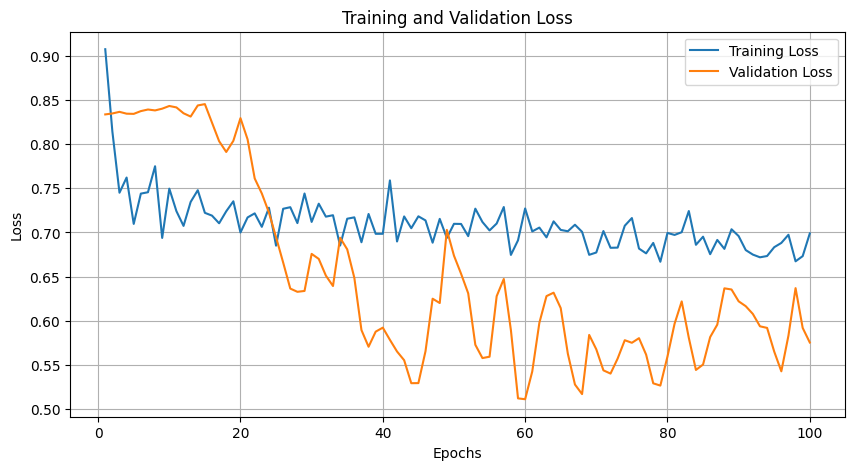

Restoring states from the checkpoint path at C:\Users\lyz\Desktop\pytorch\emissions\emissions-epoch=58-val_loss=0.51-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\lyz\Desktop\pytorch\emissions\emissions-epoch=58-val_loss=0.51-v2.ckpt
c:\Users\lyz\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mae          │        45745796.0         │
│          test_r2          │    0.7749372124671936     │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 45745796.0, 'test_r2': 0.7749372124671936}]

In [12]:
from pytorch_lightning import seed_everything

seed_everything(hparams.init_seed) # 固定随机种子

df, pt = preprocess_data(hparams.data_path) # 预处理数据并保存变换器

model = EmissionsPredictor(hparams=hparams, pt=pt)

# Trainer
earlystopping = EarlyStopping('val_loss', patience=hparams.patience, verbose=True, min_delta=0.00, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                        mode='min',
                                        dirpath='emissions',
                                        filename='emissions-{epoch:02d}-{val_loss:.2f}',
                                        save_top_k=1)
progress_bar = TQDMProgressBar()

callback = [earlystopping, checkpoint_callback, progress_bar, loss_logger]
trainer = pl.Trainer(max_epochs=hparams.max_epochs, callbacks=callback, accelerator='gpu',
                      devices=1, logger=True,
                    #   profiler='simple'
                        )

# DataModule
dm = EmissionsDataModule(hparams=hparams, df=df, pt=pt)

trainer.fit(model, datamodule=dm)

best_model_path = trainer.checkpoint_callback.best_model_path

# 测试
trainer.test(
    model=model,
    datamodule=dm,
    ckpt_path=best_model_path
)

In [13]:
from pytorch_lightning import cli_lightning_logo
cli_lightning_logo()



                    ####
                ###########
             ####################
         ############################
    #####################################
##############################################
#########################  ###################
#######################    ###################
####################      ####################
##################       #####################
################        ######################
#####################        #################
######################     ###################
#####################    #####################
####################   #######################
###################  #########################
##############################################
    #####################################
         ############################
             ####################
                  ##########
                     ####


